In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,auc, classification_report, plot_confusion_matrix
#from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers import Dense, Input, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
#from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, GlobalMaxPool2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input

In [32]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [33]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [34]:
#mount the drive into the colab notebook
drive = GoogleDrive(gauth)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!pip install -q kaggle

In [36]:
from google.colab import files

In [ ]:
files.upload()

In [38]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [39]:
! kaggle datasets download -d paultimothymooney/blood-cells

blood-cells.zip: Skipping, found more recently modified local copy (use --force to force download)


In [40]:
! unzip -q '/content/blood-cells.zip'

replace dataset-master/dataset-master/Annotations/BloodImage_00000.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### EDA

In [41]:
PATH = '/content/dataset2-master/dataset2-master/images/TRAIN'
print (os.listdir(PATH))

files_eosinophils = os.listdir ('/content/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL')
num_eosinophils = len(files_eosinophils)
print ("Total images of eosinophils ", num_eosinophils)

files_lymphocyte = os.listdir ('/content/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE')
num_lymphocyte = len(files_lymphocyte)
print ("Total images of lymphocytes ", num_lymphocyte)

files_monocyte = os.listdir ('/content/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE')
num_monocyte = len(files_monocyte)
print ("Total images of monocytes ", num_monocyte)

files_neutrophil = os.listdir ('/content/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL')
num_neutrophil = len(files_neutrophil)
print ("Total images of neutrophils ", num_neutrophil)

['MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL']
Total images of eosinophils  2497
Total images of lymphocytes  2483
Total images of monocytes  2478
Total images of neutrophils  2499


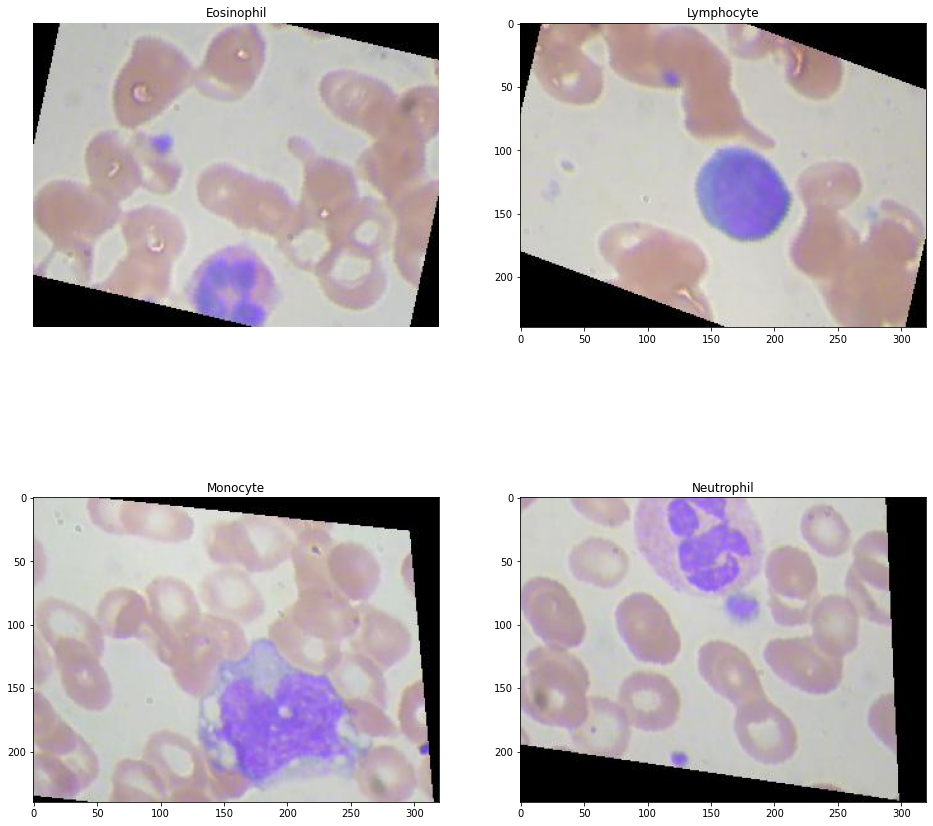

In [42]:
img_eosinophil = plt.imread('/content/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg')
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(img_eosinophil)
plt.title('Eosinophil')
plt.axis('off')

img_lymphocyte = plt.imread('/content/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_1063.jpeg')
plt.subplot(222)
plt.imshow(img_lymphocyte)
plt.title('Lymphocyte')

img_monocyte = plt.imread('/content/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_1173.jpeg')
plt.subplot(223)
plt.imshow(img_monocyte)
plt.title('Monocyte')

img_neutrophil = plt.imread('/content/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_1095.jpeg')
plt.subplot(224)
plt.imshow(img_neutrophil)
plt.title('Neutrophil')

plt.show()

In [43]:
# example of esoniphil
dims = np.shape(img_eosinophil)
print(dims)

(240, 320, 3)


In [44]:
np.min(img_eosinophil), np.max(img_eosinophil)

(0, 255)

### Building a model


In [45]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 10,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

test_gen = ImageDataGenerator(rescale = 1./255)

In [46]:
train = train_gen.flow_from_directory('/content/dataset2-master/dataset2-master/images/TRAIN',
                                      target_size = (64, 64),
                                      batch_size = 16,
                                      class_mode = 'categorical')

test = test_gen.flow_from_directory('/content/dataset2-master/dataset2-master/images/TEST',
                                    target_size = (64, 64),
                                    batch_size = 16,
                                    class_mode = 'categorical',
                                    shuffle = False)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


#### Model 1 - best results

In [47]:
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation = 'relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

#model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))

model.add(Dense(4, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)         

In [49]:
earlystopping_callback = EarlyStopping( monitor="val_loss", min_delta=0.0001, patience=8, restore_best_weights=True)
keras_callbacks = [earlystopping_callback]

In [50]:
history = model.fit(train,epochs = 100, validation_data = test, callbacks = keras_callbacks)

Epoch 1/100
623/623 [==============================] - 30s 48ms/step - loss: 1.3868 - accuracy: 0.2518 - val_loss: 1.3850 - val_accuracy: 0.2493
Epoch 2/100
623/623 [==============================] - 28s 45ms/step - loss: 1.3610 - accuracy: 0.3064 - val_loss: 1.2326 - val_accuracy: 0.4306
Epoch 3/100
623/623 [==============================] - 28s 45ms/step - loss: 1.2454 - accuracy: 0.4005 - val_loss: 1.0921 - val_accuracy: 0.4439
Epoch 4/100
623/623 [==============================] - 27s 44ms/step - loss: 1.1453 - accuracy: 0.4574 - val_loss: 0.9910 - val_accuracy: 0.5356
Epoch 5/100
623/623 [==============================] - 28s 44ms/step - loss: 1.0041 - accuracy: 0.5419 - val_loss: 0.9310 - val_accuracy: 0.5702
Epoch 6/100
623/623 [==============================] - 27s 44ms/step - loss: 0.8537 - accuracy: 0.6180 - val_loss: 0.7978 - val_accuracy: 0.6630
Epoch 7/100
623/623 [==============================] - 27s 44ms/step - loss: 0.7586 - accuracy: 0.6584 - val_loss: 0.8994 - val_ac

When BatchNormalization layers are applied in the model, the model tends to overfit the data. To reduce this overfitting used a Dropout layer, but the accuracy was much lower as compared to the final deeper Cov2D model used and displayed above.

In [51]:
_, acc = model.evaluate(test)
print('> %.3f' % (acc * 100.0))

156/156 [==============================] - 3s 22ms/step - loss: 0.2467 - accuracy: 0.8766
> 87.656


In [52]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


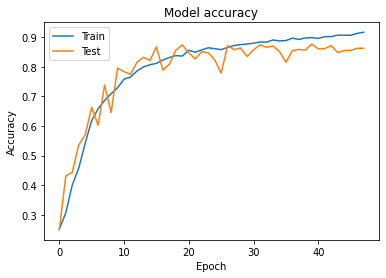

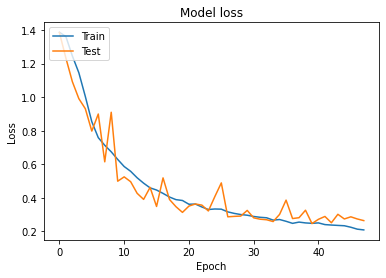

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [54]:
y_classes = model.predict_classes(test)
print(y_classes)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[3 3 0 ... 3 3 3]


In [55]:
y_test = test.classes
print(y_test)
class_labels = list(test.class_indices.keys())
print(class_labels)

[0 0 0 ... 3 3 3]
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [57]:
print(y_test.shape)
print(y_classes.shape)

(2487,)
(2487,)


In [58]:
cm = confusion_matrix(y_test, y_classes)
print(cm)

report = classification_report(y_test, y_classes, target_names=class_labels) 
print (report) 

[[373   3   0 247]
 [  0 612   8   0]
 [  0   0 614   6]
 [ 30   2  11 581]]
              precision    recall  f1-score   support

  EOSINOPHIL       0.93      0.60      0.73       623
  LYMPHOCYTE       0.99      0.99      0.99       620
    MONOCYTE       0.97      0.99      0.98       620
  NEUTROPHIL       0.70      0.93      0.80       624

    accuracy                           0.88      2487
   macro avg       0.90      0.88      0.87      2487
weighted avg       0.90      0.88      0.87      2487



#### Model 2: Creating model using transfer learning (BGG16)

In [59]:
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(64, 64, 3))


for layer in model.layers:
  model.get_layer(layer.name).trainable = False

flat1 = GlobalMaxPool2D()(model.output)
class1 = Dense(1024, activation='relu')(flat1)
class2 = Dense(128, activation='relu')(class1)

z = Dense(128, activation='relu')(class2)
output = Dense(4, activation='softmax')(z)
# define new model
model = Model(inputs=model.inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.00001), metrics=['accuracy'])

In [60]:
history_vgg = model.fit_generator(train, epochs = 100, validation_data = test, callbacks=keras_callbacks)

Epoch 1/100
623/623 [==============================] - 31s 49ms/step - loss: 1.3364 - accuracy: 0.3658 - val_loss: 1.3061 - val_accuracy: 0.3518
Epoch 2/100
623/623 [==============================] - 31s 49ms/step - loss: 1.2441 - accuracy: 0.4548 - val_loss: 1.2337 - val_accuracy: 0.4415
Epoch 3/100
623/623 [==============================] - 31s 49ms/step - loss: 1.1794 - accuracy: 0.4943 - val_loss: 1.1886 - val_accuracy: 0.4274
Epoch 4/100
623/623 [==============================] - 30s 49ms/step - loss: 1.1265 - accuracy: 0.5328 - val_loss: 1.1469 - val_accuracy: 0.4881
Epoch 5/100
623/623 [==============================] - 30s 49ms/step - loss: 1.0920 - accuracy: 0.5488 - val_loss: 1.1310 - val_accuracy: 0.4704
Epoch 6/100
623/623 [==============================] - 30s 49ms/step - loss: 1.0651 - accuracy: 0.5634 - val_loss: 1.0992 - val_accuracy: 0.4954
Epoch 7/100
623/623 [==============================] - 31s 50ms/step - loss: 1.0412 - accuracy: 0.5682 - val_loss: 1.0790 - val_ac

In [61]:
_, acc = model.evaluate(test)
print('> %.3f' % (acc * 100.0))

156/156 [==============================] - 4s 25ms/step - loss: 1.0170 - accuracy: 0.5388
> 53.880


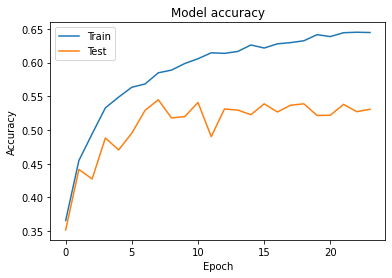

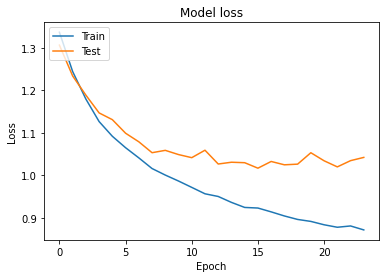

In [62]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [64]:
y_classes = model.predict(test)
print(y_classes)
y_pred = np.argmax(y_classes, axis=1)
print(y_pred)

[[0.22011632 0.20583601 0.28288653 0.2911611 ]
 [0.15548702 0.21878667 0.506661   0.1190653 ]
 [0.34508973 0.08005439 0.2415138  0.33334213]
 ...
 [0.1669151  0.13249692 0.36386287 0.3367251 ]
 [0.10111839 0.00857302 0.29440325 0.59590536]
 [0.08317115 0.04507111 0.04801194 0.8237458 ]]
[3 2 0 ... 2 3 3]


In [65]:
y_test = test.classes
print(y_test)
class_labels = list(test.class_indices.keys())
print(class_labels)

[0 0 0 ... 3 3 3]
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [66]:
print(y_test.shape)
print(y_pred.shape)

(2487,)
(2487,)


In [67]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

report = classification_report(y_test, y_pred, target_names=class_labels) 
print (report) 

[[202 161 110 150]
 [ 52 488  13  67]
 [129   4 204 283]
 [ 79  54  45 446]]
              precision    recall  f1-score   support

  EOSINOPHIL       0.44      0.32      0.37       623
  LYMPHOCYTE       0.69      0.79      0.74       620
    MONOCYTE       0.55      0.33      0.41       620
  NEUTROPHIL       0.47      0.71      0.57       624

    accuracy                           0.54      2487
   macro avg       0.54      0.54      0.52      2487
weighted avg       0.54      0.54      0.52      2487



#### Conclusion:
The first model has better results for this dataset as compared to the larger transfer learning model (VGG16).
All metrics like accuracy, confusion matrix, precision, f1 score and recall, are much higher in the first model as compared to vgg16 model.